<a href="https://colab.research.google.com/github/SCS-Technology-and-Innovation/DACS/blob/main/DTDA/resist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### The last straw

In this module, we will see what it takes to break things down. Based on that, we can figure out which elements are the most vital ones to keep things together.

We will use a new network model. This is a *small-world network model* in which the vertices form tightly-connected neighborhoods and the average distance is low (log-log for the vertex count). Our particular choice of model is the Watts-Strogatz model published in [Nature](https://www.nature.com/articles/30918) in the late nineties.

In [12]:
import networkx as nx
n = 70
G1 = nx.connected_watts_strogatz_graph(n, 2, 0.3)
m = G1.number_of_edges()
m

70

To see what it looks like, we can use a circular layout like in our SIR model.

In [13]:
L1 = nx.circular_layout(G1)

import matplotlib.pyplot as plt
fig = plt.figure(1, figsize = (4, 4), dpi =  100)
nx.draw(G1, L1, node_size = 25)

Let's dig into the concept of *distance* by picking a random pair of vertices and seeing what kinds of paths exist between them.

In [14]:
from random import sample
pair = sample(G1.nodes, 2)
source = pair[0]
target = pair[1]
print(pair, 0 in G1.nodes, n in G1.nodes)

[11, 57] True False


<ipython-input-14-10f8118662fb>:2: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  pair = sample(G1.nodes, 2)


We can visualize these by assigning a specific color to those two vertices.

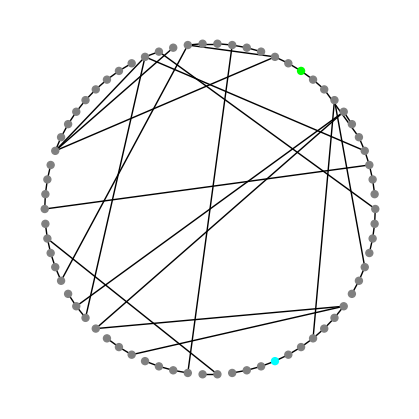

In [15]:
colors = [ 'gray' ] * n
colors[source] = 'lime'
colors[target] = 'cyan'
fig = plt.figure(1, figsize = (4, 4), dpi =  100)
nx.draw(G1, L1, node_size = 25, node_color = colors)

The calculation of the *shortest path* that connects them can be achieved efficiently by *Dijkstra's algorithm*.

A **path** is any sequence of vertices that respects the edges present in the graph.

The **length** of a path is the number of edges it traverses.

*Shortest* paths are those that minimize the length.

The minimal path length between two vertices is called the **distance** between them.

If there is no path, then the two vertices are **disconnected**.

If there is at least one path, they are **connected**.

In [16]:
path = nx.dijkstra_path(G1, source, target)
path

[11, 12, 13, 31, 22, 43, 42, 7, 44, 63, 62, 61, 60, 59, 58, 57]

If we want to color the edges used by this path, we need to recover the edge information from this sequence.

In [17]:
P = []
current = path[0]
for pos in range(1, len(path)):
  following = path[pos]
  P.append((current, following))
  current = following
P

[(11, 12),
 (12, 13),
 (13, 31),
 (31, 22),
 (22, 43),
 (43, 42),
 (42, 7),
 (7, 44),
 (44, 63),
 (63, 62),
 (62, 61),
 (61, 60),
 (60, 59),
 (59, 58),
 (58, 57)]

The graph model may contain the edge with a specific *orientation*, but the **traversal** along the path might not respect this. Hence, we should also consider the opposite directions along each individual edge.

In [18]:
E1 = set(P)
E2 = set([ (v, u) for (u, v) in P ])
E = E1 | E2
E

{(7, 42),
 (7, 44),
 (11, 12),
 (12, 11),
 (12, 13),
 (13, 12),
 (13, 31),
 (22, 31),
 (22, 43),
 (31, 13),
 (31, 22),
 (42, 7),
 (42, 43),
 (43, 22),
 (43, 42),
 (44, 7),
 (44, 63),
 (57, 58),
 (58, 57),
 (58, 59),
 (59, 58),
 (59, 60),
 (60, 59),
 (60, 61),
 (61, 60),
 (61, 62),
 (62, 61),
 (62, 63),
 (63, 44),
 (63, 62)}

Now we are ready to color the path in the visualization.

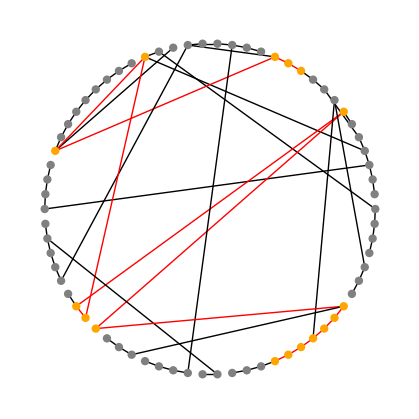

In [19]:
for v in path:
  colors[v] = 'orange'

Ec = [ 'red' if (v, u) in E else 'black' for v, u in G1.edges ]

fig = plt.figure(1, figsize = (4, 4), dpi =  100)
nx.draw(G1, L1, node_size = 25, node_color = colors, edge_color = Ec)

Another useful, famous, and efficient algorithm is that of Floyd and Warshall that gives us **all** of the vertex-to-vertex distances (in a dictionary, when we use the `nx` implementation).

In [20]:
distance = nx.floyd_warshall(G1)
distance[source][target]

15.0

We can sum all of them and then normalize to compute the *average* distance.

In [21]:
total = 0
for v in G1:
    for u in G1:
        if v != u:
          total += distance[v][u]
count = n**2 - n
print(total / count)

9.376811594202898


There is, of course, also a routine in `nx` to request this directly.

In [22]:
nx.average_shortest_path_length(G1)

9.376811594202898

Now, what happens to the graph if we remove vertices one at a time at random? The study of the effects of such iterated, randomized elimination of a single element is known as *percolation*.

As the graph breaks into pieces (called *connected components*),

In [23]:
from random import choice

while True:
  broken = choice(list(G1.nodes))
  G1.remove_node(broken)
  nNow = G1.number_of_nodes()
  mNow = G1.number_of_edges()
  print(f'{nNow} vertices, down from {n}')
  print(f'{mNow} edges, down from {m}')
  comp = [ cc for cc in nx.connected_components(G1) ]
  if len(comp) > 1: # it broke into pieces
    break
  avgd = nx.average_shortest_path_length(G1)
  print(f'Avg distance now at {avgd:.2f}')

69 vertices, down from 70
67 edges, down from 70


Once the graph breaks into disconnected parts, we can look at the orders of the resulting components.

Order = number of vertices
Size = number of edges

In [24]:
for cc in comp:
  print(len(cc))

50
1
18


Let's make a more densely connected small-world graph and see what changes. Now we request each vertex to have a direct edge to four immediate neighbors, along the circle, on each side.

In [25]:
n = 70
G2 = nx.connected_watts_strogatz_graph(n, 4, 0.3)
G2.number_of_edges()

140

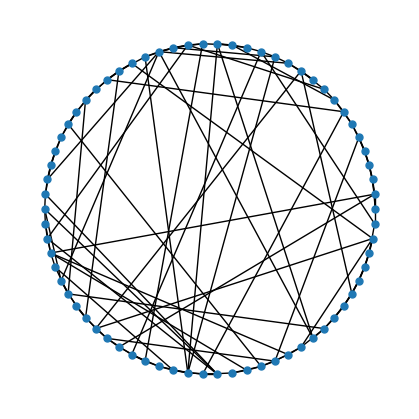

In [26]:
L2 = nx.circular_layout(G2) # we will not see most of the KNN edges
fig = plt.figure(1, figsize = (4, 4), dpi =  100)
nx.draw(G2, L2, node_size = 25)

The visualization hides the edges to second and third neighbors. Let's try another layout.

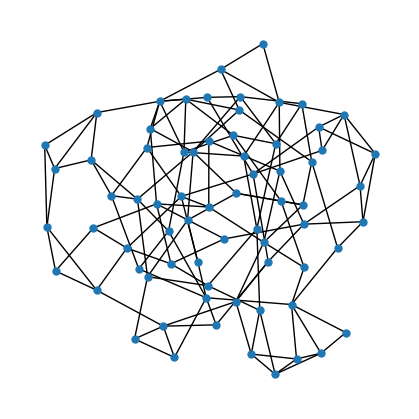

In [27]:
L2 = nx.kamada_kawai_layout(G2)
fig = plt.figure(1, figsize = (4, 4), dpi =  100)
nx.draw(G2, L2, node_size = 25)

Let's build an animation that lets us see the components during percolation.

In [28]:
percolated = G2.copy()
ccc = [ 'blue', 'red', 'purple', 'orange', 'lime', 'gold', 'hotpink', 'cornflowerblue', 'black' ] # the last one is default if we run out
fade = set()
growth = [] # let's keep track of the avg distance while we hammer away

def start():
  nx.draw(G2, L2, node_size = 25)

def percolate(t):
  global percolated, fade
  comp = [ cc for cc in nx.connected_components(percolated) ]
  if len(comp) == 1: # still in one piece
    growth.append(nx.average_shortest_path_length(percolated))
  # color the components (on the original graph)
  Vc = [ 'lightgray' for v in G2.nodes ] # grayed out is default
  i = 0 # start with the first color
  for cc in comp: # iterate over the components that are present
    compColor = ccc[i]
    for v in cc: # for each vertex in that component
      Vc[v] = ccc[i]
    if i < len(ccc) - 1: # if there are more colors available
      i += 1 # change to the next color
  if percolated.number_of_nodes() > 1:
    v = choice(list(percolated.nodes))
    Vc[v] = 'lightgray' # fade out
    for u in G2.neighbors(v):
      fade.add((u, v))
      fade.add((v, u))
    percolated.remove_node(v)
  Ec = [ 'lightgray' if e in fade else 'black' for e in G2.edges() ]
  plt.clf()
  nx.draw(G2, L2, node_size = 25, node_color = Vc, edge_color = Ec)

Now, the slow part (adjust duration if this is too slow to compute)

In [29]:
from matplotlib import rc
rc('animation', html='jshtml')
import matplotlib.animation as animation

duration = n // 2 # take half of them away
fig = plt.figure(1, figsize = (4, 4), dpi =  100)
animation.FuncAnimation(fig, percolate, frames = duration, interval = 400, repeat = False, init_func = start())

We can track what happens to the average distance since we recorded it.

In [30]:
fig = plt.figure(figsize = (12, 5), dpi =  100)
l = len(growth)
plt.xlim(-0.5, l - 0.5)
low = min(growth)
high = max(growth)
margin = 0.05 * (high + low) / 2
plt.ylim(low - margin, high + margin)
t = [ i for i in range(l) ]
plt.plot(t, growth, c = 'purple', marker = 'o')
plt.xlabel('Amount of vertices removed')
plt.ylabel('Average distance')
plt.show()

Some vertices cause much bigger **bumps** than others. Also, what is the reason it sometimes goes *down*? (Let's pause here until everyone understands this.)

# Centrality

There are measures specifically crafted to identify "heavy-impact" vertices, such as centrality measures.

In [31]:
importance = nx.betweenness_centrality(G2)
high = max(importance.values())
print(high)
print(min(importance.values()))
importance[source]

0.10654055462615715
0.0


0.06586865930930923

In [ ]:
An easy way to visualize this would by using the centrality to color the vertices.

In [32]:
tones = 12
color = [ (importance[v] / high) * tones for v in G2.nodes ]
color[:4]

[0.0, 11.384445292230716, 0.884582062520898, 1.3177836169831254]

In [33]:
color = [ round(c) for c in color ]
color[:4]

[0, 11, 1, 1]

In [35]:
L2 = nx.kamada_kawai_layout(G2)
fig = plt.figure(1, figsize = (4, 4), dpi =  150)
nx.draw(G2, L2, node_size = 25, node_color = color, cmap = plt.cm.Oranges)
fig.set_facecolor('gray')
plt.show()